In [1]:
from fastmri.data import transforms as T
import fastmri
import torch
import tensorflow as tf
import torch.fft as fft 
import h5py
import numpy as np
from matplotlib import pyplot as plt

2023-12-08 09:30:50.885394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 09:30:50.885439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 09:30:50.887262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 09:30:50.897664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 09:30:58.136489: W tensorflow/compiler/tf2

In [2]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)


In [3]:
def virtual_coil_reconstruction(imgs):
    """
    Calculate the combination of all coils using virtual coil reconstruction

    Parameters
    ----------
    imgs: np.ndarray
        The images reconstructed channel by channel
        in shape [batch_size, Nch, Nx, Ny, Nz]

    Returns
    -------
    img_comb: np.ndarray
        The combination of all the channels in a complex valued
        in shape [batch_size, Nx, Ny]
    """
    imgs = torch.tensor(imgs, dtype=torch.complex64)
    img_sh = imgs.shape
    dimension = len(img_sh)-2

    weights = tf.math.reduce_sum(tf.abs(imgs), axis=1) + 1e-16
    phase_reference = tf.cast(
        tf.math.angle(tf.math.reduce_sum(
            imgs,
            axis=(2+np.arange(len(img_sh)-2))
        )),
        tf.complex64
    )
    expand = [..., *((None, ) * (len(img_sh)-2))]
    reference = imgs / tf.cast(weights[:, None, ...], tf.complex64) / \
        tf.math.exp(1j * phase_reference)[expand]
    virtual_coil = tf.math.reduce_sum(reference, axis=1)
    difference_original_vs_virtual = tf.math.conj(imgs) * virtual_coil[:, None]

    hanning = tf.signal.hann_window(img_sh[-dimension])
    for d in range(dimension-1):
        hanning = tf.expand_dims(hanning, axis=-1) * tf.signal.hann_window(img_sh[dimension + d])
    hanning = tf.cast(hanning, tf.complex64)

    if dimension == 3:    
        difference_original_vs_virtual = tf.signal.ifft3d(
            tf.signal.fft3d(difference_original_vs_virtual) * tf.signal.fftshift(hanning)
        )
    else:
        difference_original_vs_virtual = tf.signal.ifft2d (
            tf.signal.fft2d(difference_original_vs_virtual) * hanning
        )
    img_comb = tf.math.reduce_sum(
        imgs *
        tf.math.exp(
            1j * tf.cast(tf.math.angle(difference_original_vs_virtual), tf.complex64)),
        axis=-3
    )
    return img_comb

In [4]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
hf = h5py.File(file_path)

In [5]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 16, 640, 320)


In [6]:
slice_kspace = volume_kspace[volume_kspace.shape[0]-1] # Choosing the lastest slice of this volume
# print(slice_kspace)

In [7]:
num_coils = slice_kspace.shape[0] # number of coils in the k-space
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
print(slice_kspace2.shape)
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
print(slice_image.shape)
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
print(slice_image_abs.shape)

# for coil_index in range(num_coils):
#     show_coils(np.log(np.abs(slice_kspace) + 1e-9), [coil_index])
#     show_coils(slice_image_abs, [coil_index], cmap='gray')

torch.Size([16, 640, 320, 2])
torch.Size([16, 640, 320, 2])
torch.Size([16, 640, 320])


/tmp/ipykernel_4016063/932307776.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(imgs, dtype=torch.complex64)
2023-12-08 09:31:12.126966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 300 MB memory:  -> device: 0, name: Quadro M4000, pci bus id: 0000:03:00.0, compute capability: 5.2


(640, 320)


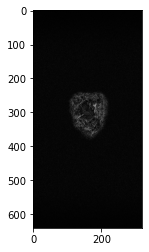

In [8]:
new_image_singlecoil = virtual_coil_reconstruction(slice_image_abs)
print(new_image_singlecoil.shape)
plt.imshow(np.abs(new_image_singlecoil.numpy()), cmap='gray')